# Explorations of PCAP files from contagio malware dump
<div style="float: right;"><img src="files/images/Malware.jpg" width="300px"></div>

### Tools
<font size=4>
<ul>
    <li>Bro (http://www.bro.org)
    <li>IPython (http://www.ipython.org)
    <ul><li>pandas (http://pandas.pydata.org)
        <li>matplotlib (http://matplotlib.org/)
    </ul><li>Maxmind GeoLite ASN (http://dev.maxmind.com/geoip/legacy/geolite/)
    <li>Flare (http://flare.prefuse.org/) Layouts:
    <ul><li>https://gist.github.com/mbostock/4339607
    <li>https://gist.github.com/mbostock/4063570
    </ul>
</ul>
</font>

### Data

<font size=4>
<ul>
      <li>contagio malware dump PCAP collection (http://contagiodump.blogspot.com/2013/04/collection-of-pcap-files-from-malware.html)
</ul>
</font>

### What we did:

<font size=4>
<ul>
    <li>Data gathered with Bro (default Bro content) 
    <ul><li>bro -C -r &#60;pcap&#62; local
    </ul>
    <li>Data cleanup
    <ul><li>Had to remove "s from the various smtp logs due to errors with pandas read_csv expecting " surrounding a field vs. in a field
    </ul>
    <li>Augmented connection records with Maxmind ASN Database (download and unzip in the same directory as this notebook)
    <li>Explored the Data!
</ul>
</font>

### Additional notes:

<font size=4>
All of this data has been contributed to contagio by various sources. The methods of traffic capture/generation/sandbox setup probably varies widly between most (all?) samples. This underscores the need for good data when doing analysis, but in this case we're going to make the best of what we've got.
<br><br>
Thanks to everybody who selflessly contibutes data to sites like contagio, keep up the great work!
</font>

In [2]:
import pandas as pd
import numpy as np
import string
import pylab
import re
import pandas
import time
import os
import collections
import matplotlib
import struct
import socket
import json
from datetime import datetime
from netaddr import IPNetwork, IPAddress

%matplotlib inline


pylab.rcParams['figure.figsize'] = (16.0, 5.0)

In [4]:
# Mapping of fields of the files we want to read in and initial setup of pandas dataframes
logs_to_process = {
                    'conn.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','service','duration','orig_bytes','resp_bytes','conn_state','local_orig','missed_bytes','history','orig_pkts','orig_ip_bytes','resp_pkts','resp_ip_bytes','tunnel_parents','threat','sample'],
                    'dns.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','proto','trans_id','query','qclass','qclass_name','qtype','qtype_name','rcode','rcode_name','AA','TC','RD','RA','Z','answers','TTLs','rejected','threat','sample'],
                    'files.log' : ['ts','fuid','tx_hosts','rx_hosts','conn_uids','source','depth','analyzers','mime_type','filename','duration','local_orig','is_orig','seen_bytes','total_bytes','missing_bytes','overflow_bytes','timedout','parent_fuid','md5','sha1','sha256','extracted','threat','sample'],
                    'ftp.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','user','password','command','arg','mime_type','file_size','reply_code','reply_msg','data_channel.passive','data_channel.orig_h','data_channel.resp_h','data_channel.resp_p','fuid','threat','sample'],
                    'http.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','trans_depth','method','host','uri','referrer','user_agent','request_body_len','response_body_len','status_code','status_msg','info_code','info_msg','filename','tags','username','password','proxied','orig_fuids','orig_mime_types','resp_fuids','resp_mime_types','threat','sample'],
                    'notice.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','fuid','file_mime_type','file_desc','proto','note','msg','sub','src','dst','p','n','peer_descr','actions','suppress_for','dropped','remote_location.country_code','remote_location.region','remote_location.city','remote_location.latitude','remote_location.longitude','threat','sample'],
                    'signatures.log' : ['ts','src_addr','src_port','dst_addr','dst_port','note','sig_id','event_msg','sub_msg','sig_count','host_count','threat','sample'],
                    'smtp.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','trans_depth','helo','mailfrom','rcptto','date','from','to','reply_to','msg_id','in_reply_to','subject','x_originating_ip','first_received','second_received','last_reply','path','user_agent','fuids','is_webmail','threat','sample'],
                    'ssl.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','version','cipher','server_name','session_id','subject','issuer_subject','not_valid_before','not_valid_after','last_alert','client_subject','client_issuer_subject','cert_hash','validation_status','threat','sample'],
                    'tunnel.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','tunnel_type','action','threat','sample'],
                    'weird.log' : ['ts','uid','id.orig_h','id.orig_p','id.resp_h','id.resp_p','name','addl','notice','peer','threat','sample']
                  }

conndf   = pd.DataFrame(columns=logs_to_process['conn.log'])
dnsdf    = pd.DataFrame(columns=logs_to_process['dns.log'])
filesdf  = pd.DataFrame(columns=logs_to_process['files.log'])
ftpdf    = pd.DataFrame(columns=logs_to_process['ftp.log'])
httpdf   = pd.DataFrame(columns=logs_to_process['http.log'])
noticedf = pd.DataFrame(columns=logs_to_process['notice.log'])
sigdf    = pd.DataFrame(columns=logs_to_process['signatures.log'])
smtpdf   = pd.DataFrame(columns=logs_to_process['smtp.log'])
ssldf    = pd.DataFrame(columns=logs_to_process['ssl.log'])
tunneldf = pd.DataFrame(columns=logs_to_process['tunnel.log'])
weirddf  = pd.DataFrame(columns=logs_to_process['weird.log'])

In [5]:
# Process the directory structure
# If you download the complete PCAP zip from Contagio and unzip a structure like:
# PCAPS_TRAFFIC_PATTERNS
#      |->CRIME
#          |-> <sample>
#      |->APT
#          |-> <sample>
#      |->METASPLOIT
#          |-> <sample>
#
# Will appear and this is the structure that's walk CRIME/APT/METASPLOIT will make their way into the "threat" tag
# while the sample/PCAP name will wind up in "sample"
#
# Bro data generated via the "run_bro.sh" shell script (this places all Bro output in the respective sample directories and 
# contributes to the directory structure above
# data: GeoIPASNum2.csv, https://github.com/mlsecproject/combine/blob/master/data/GeoIPASNum2.csv

for dirName, subdirList, fileList in os.walk('.'):
    #print('Found directory: %s' % dirName)
    for fname in fileList:
        tags = dirName.split('/')
        if len(tags) == 4 and fname in logs_to_process:
            #print ('%s/%s' %(dirName, fname))
            logname = fname.split('.')
            try:
                tempdf = pd.read_csv(dirName+'/'+fname, sep='\t',skiprows=8, header=None, 
                                     names=logs_to_process[fname][:-2], skipfooter=1)
                tempdf['threat'] = tags[2]
                tempdf['sample'] = tags[3]
                if tags[2] == "0":
                    print ('%s/%s' %(dirName, fname))
                if fname == 'conn.log':
                    conndf = conndf.append(tempdf)
                if fname == 'dns.log':
                    dnsdf = dnsdf.append(tempdf)
                if fname == 'files.log':
                    filesdf = filesdf.append(tempdf)
                if fname == 'ftp.log':
                    ftpdf = ftpdf.append(tempdf)
                if fname == 'http.log':
                    httpdf = httpdf.append(tempdf)
                if fname == 'notice.log':
                    noticedf = noticedf.append(tempdf)
                if fname == 'signatures.log':
                    sigdf = sigdf.append(tempdf)
                if fname == 'smtp.log':
                    smtpdf = smtpdf.append(tempdf)
                if fname == 'ssl.log':
                    ssldf = ssldf.append(tempdf)
                if fname == 'tunnel.log':
                    tunneldf = tunneldf.append(tempdf)
                if fname == 'weird.log':
                    weirddf = weirddf.append(tempdf)
            except Exception as e:
                print("[*] error: %s, on %s/%s" % (str(e), dirName, fname))

# Read in and configure the maxmind db (free ASN), 
# encoding had been changed from "utf8" to "latin1"              
maxmind = pd.read_csv("./GeoIPASNum2.csv", sep=',', header=None, names=['low','high','asn'],encoding='latin1')
maxmind['low'] = maxmind['low'].astype(int)
maxmind['high'] = maxmind['high'].astype(int)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:27: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support skip_footer; you can avoid this warning by specifying engine='python'.


In [6]:
# Helper Functions
def ip2int(addr):               
    try:
        return struct.unpack("!I", socket.inet_aton(addr))[0]
    except Exception as e:
        pass
        #print "Error: %s - %s" % (str(e), addr)
    return 0

maxcache = {}
def maxmind_lookup(ip):
    if ip in maxcache:
        return maxcache[ip]
    i = ip2int(ip)
    if i == 0:
        return "UNKNOWN"
    results = list(maxmind.loc[(maxmind["low"] < i) & (maxmind['high'] > i)]['asn'])
    if len(results) > 0:
        maxcache[ip] = results[0]
        return results[0]
    maxcache[ip] = "UNKNOWN"
    return "UNKNOWN"

def box_plot_df_setup(series_a, series_b): 
    # Count up all the times that a category from series_a
    # matches up with a category from series_b. This is
    # basically a gigantic contingency table
    cont_table = collections.defaultdict(lambda : collections.Counter())
    for val_a, val_b in zip(series_a.values, series_b.values):
        cont_table[val_a][val_b] += 1
    
    # Create a dataframe
    # A dataframe with keys from series_a as the index, series_b_keys
    # as the columns and the counts as the values.
    #dataframe = pd.DataFrame(cont_table.values(), index=cont_table.keys())
    dataframe = pd.DataFrame(list(cont_table.values()), index=list(cont_table.keys()))

    dataframe.fillna(0, inplace=True)
    return dataframe

def is_ip(ip):
    try:
        socket.inet_aton(ip)
        return True
    except socket.error:
        return False

In [7]:
# misc cleanup of the Bro conn.log dataframe
try:
    conndf.orig_bytes[conndf.orig_bytes == '-'] = 0
except Exception as e:
    pass
try:
    conndf.resp_bytes[conndf.resp_bytes == '-'] = 0
except Exception as e:
    pass
#conndf['orig_bytes'] = conndf['orig_bytes'].astype(long)
#conndf['resp_bytes'] = conndf['resp_bytes'].astype(long)
conndf['orig_bytes'] = conndf['orig_bytes'].astype(int)
conndf['resp_bytes'] = conndf['resp_bytes'].astype(int)
conndf['total_bytes'] = conndf['orig_bytes'] + conndf['resp_bytes']

# and augmentation (asn)
conndf['maxmind_asn'] = conndf['id.resp_h'].map(maxmind_lookup)
# add date
good_datetime = [datetime.fromtimestamp(float(date)) for date in conndf['ts'].values]
conndf['date'] = pd.Series(good_datetime, index=conndf.index)

# reindex the dataframes
conndf = conndf.reindex()
httpdf = httpdf.reindex()
dnsdf = dnsdf.reindex()
noticedf = noticedf.reindex()
filesdf = filesdf.reindex()
smtpdf = smtpdf.reindex()

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  app.launch_new_instance()
/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


<div style="float: right;"><img src="files/images/dataprocessing.jpg" width="300px"></div>
## High-level overview of the data
The goal here is to get a brief understanding of the amount of data that we're dealing with after reading all of the log files in. This includes understanding the "how-many-of-each", the "when", and the "what".
### Times of activity

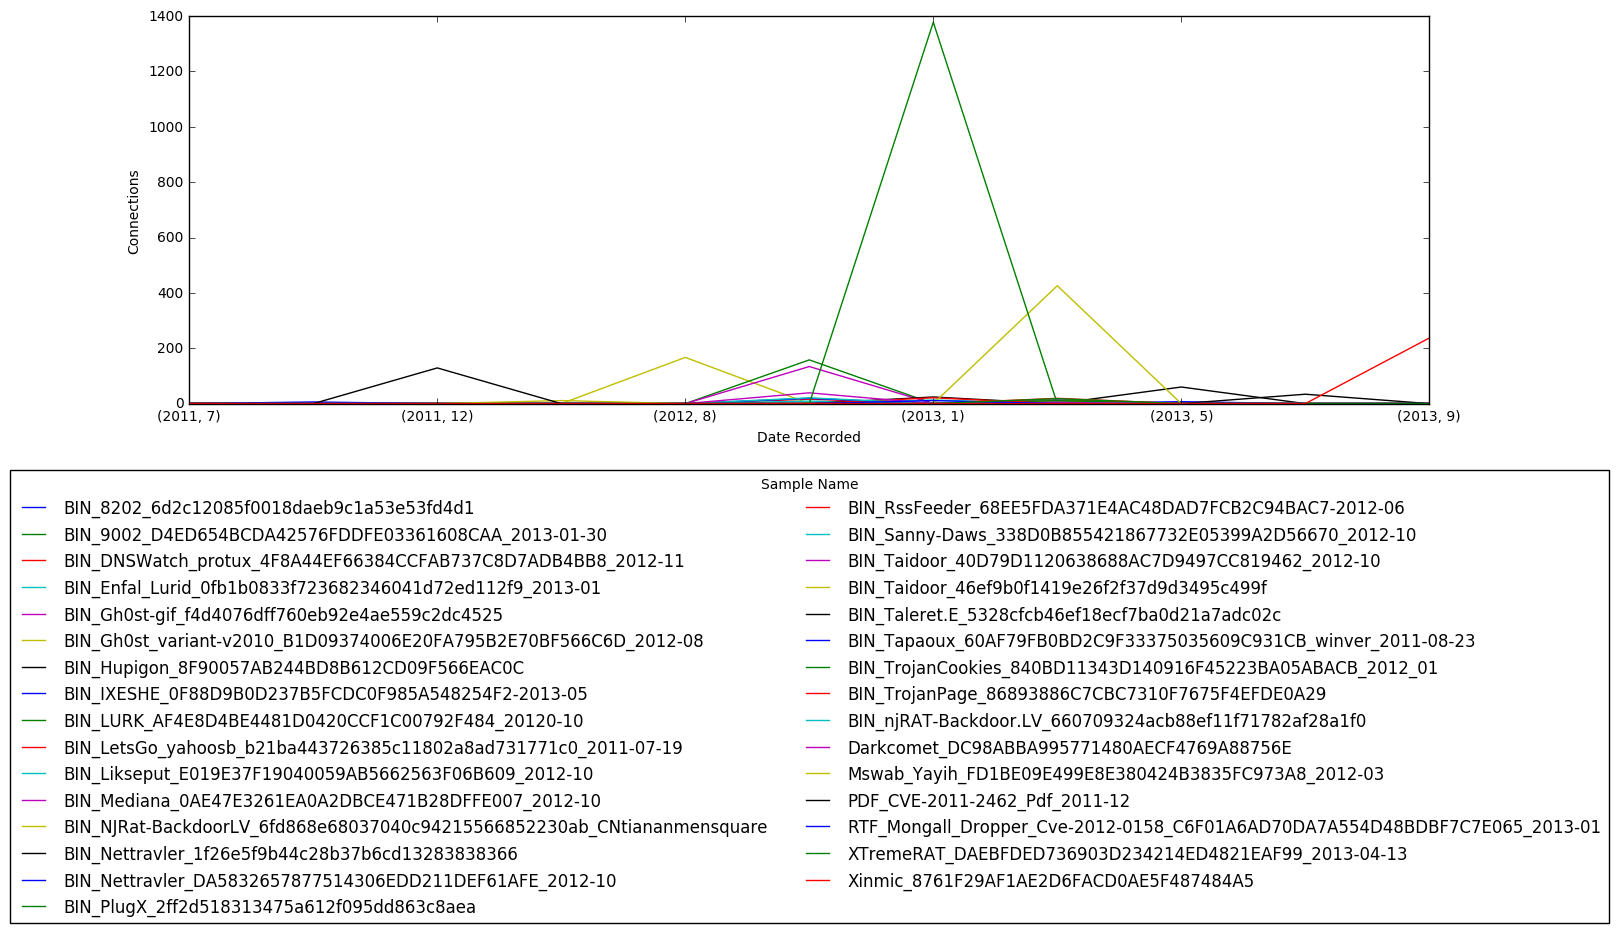

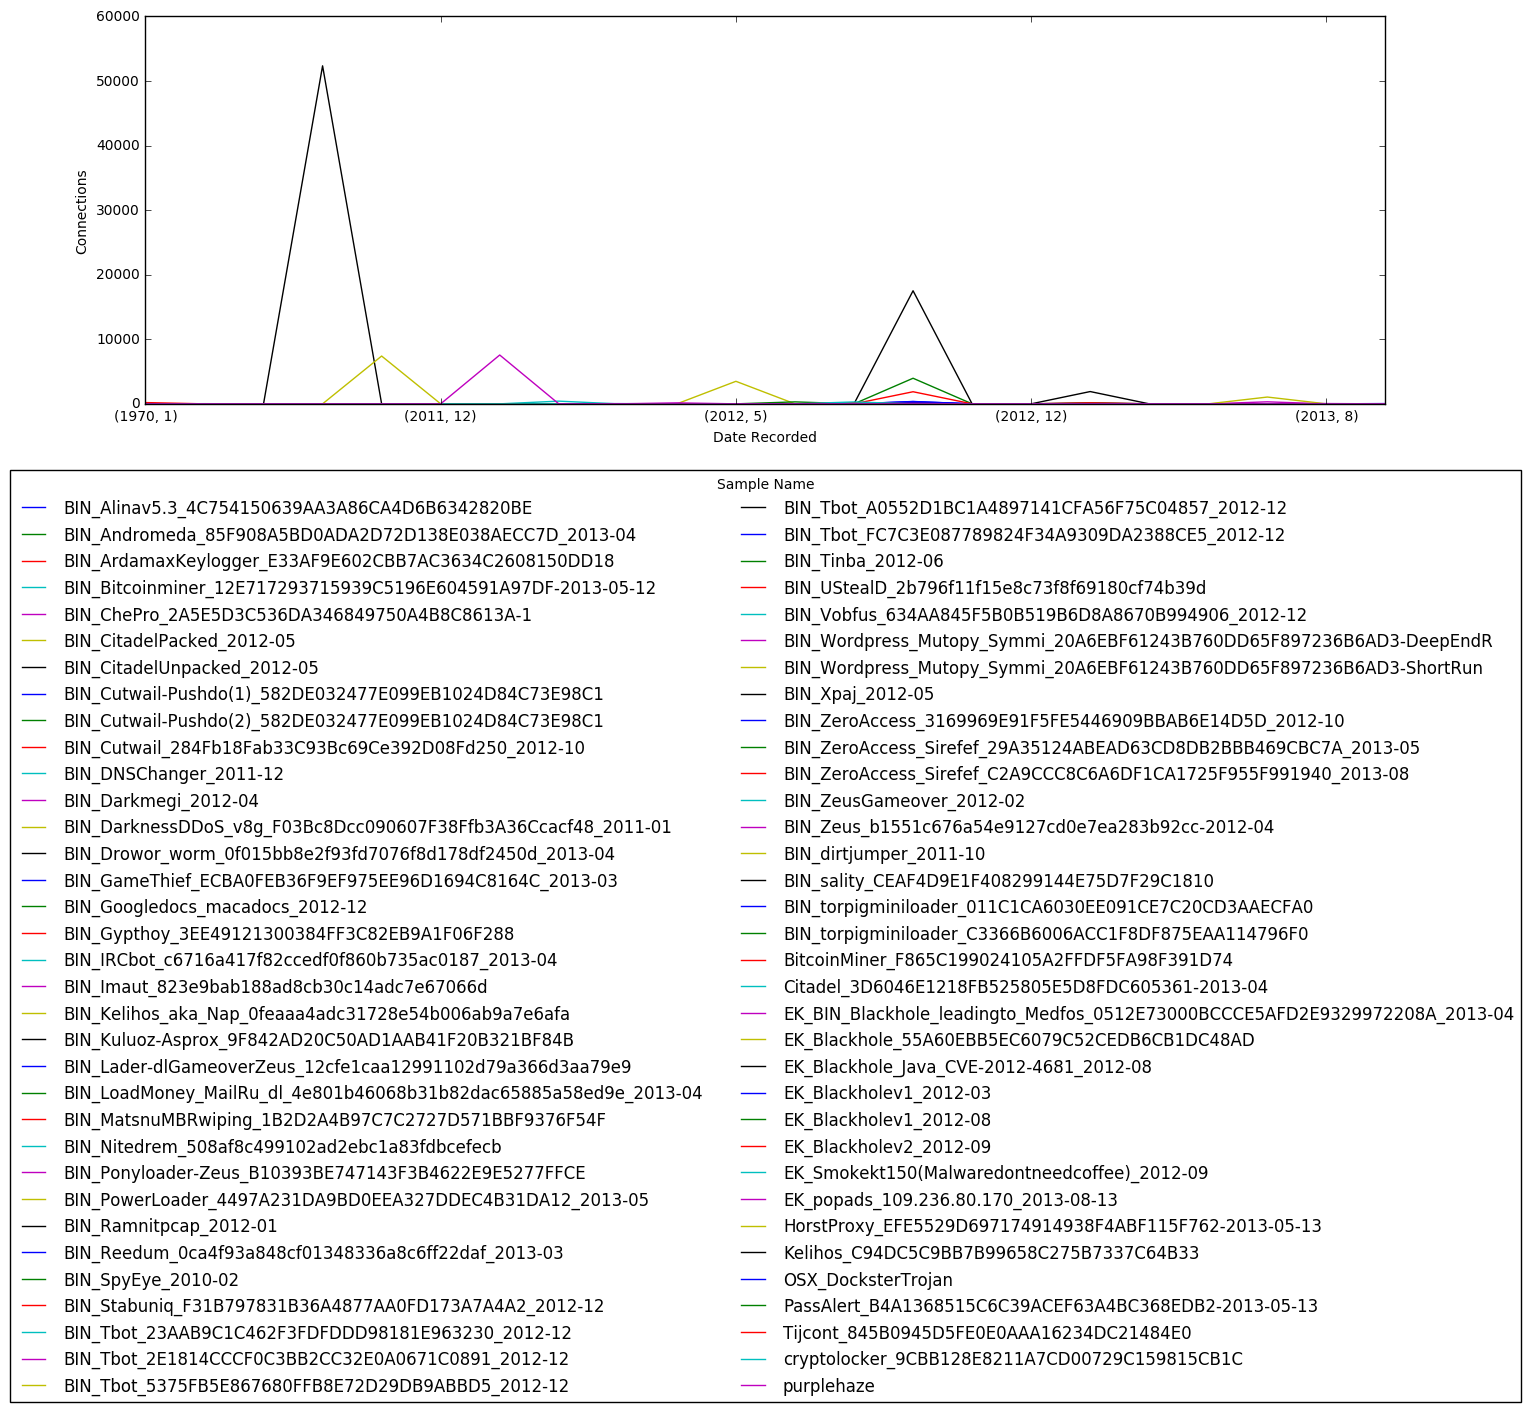

In [8]:
for threat in ['APT', 'CRIME']:
    subset = conndf[conndf['threat'] == threat][['date','sample']]
    subset['count'] = 1
    #pivot = pd.pivot_table(subset, values='count', rows=['date'], cols=['sample'], fill_value=0)
    pivot = pd.pivot_table(subset, values='count', index=['date'], columns=['sample'], fill_value=0)
    by = lambda x: lambda y: getattr(y, x)
    grouped = pivot.groupby([by('year'),by('month')]).sum()
    
    ax = grouped.plot()
    pylab.ylabel('Connections')
    pylab.xlabel('Date Recorded')
    patches, labels = ax.get_legend_handles_labels()
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=2, title="Sample Name")

### General Stats
Here we can just get a feeling of the various high-level dimensions of the data

In [9]:
print("Total Samples:          %s" % conndf['sample'].nunique())
print("")
print("APT Samples:            %s" % conndf[conndf['threat'] == 'APT']['sample'].nunique())
print("Crime Samples:          %s" % conndf[conndf['threat'] == 'CRIME']['sample'].nunique())
print("Metasploit Samples:     %s" % conndf[conndf['threat'] == 'METASPLOIT']['sample'].nunique())
print("")
print("Connection Log Entries: %s" % conndf.shape[0])
print("DNS Log Entries:        %s" % dnsdf.shape[0])
print("HTTP Log Entries:       %s" % httpdf.shape[0])
print("Files Log Entries:      %s" % filesdf.shape[0])
print("SMTP Log Entries:       %s" % smtpdf.shape[0])
print("Weird Log Entries:      %s" % weirddf.shape[0])
print("SSL Log Entries:        %s" % ssldf.shape[0])
print("Notice Log Entries:     %s" % noticedf.shape[0])
print("Tunnel Log Entries:     %s" % tunneldf.shape[0])
print("Signature Log Entries:  %s" % sigdf.shape[0])


Total Samples:          105

APT Samples:            31
Crime Samples:          68
Metasploit Samples:     6

Connection Log Entries: 104413
DNS Log Entries:        108371
HTTP Log Entries:       22927
Files Log Entries:      19289
SMTP Log Entries:       4088
Weird Log Entries:      1081
SSL Log Entries:        351
Notice Log Entries:     252
Tunnel Log Entries:     2
Signature Log Entries:  1


### Security Workflow Breakdown

This is an example of how to go from an alert (in this case a Bro signature match) to gathering information about the alert via the other data in just a few lines of code.

We'll want to
<ul>
    <li>Find the signatures that fired
    <li>Grab the destination address for each signature
    <li>For each destination address gather:
        <ul><li>Basic flow information
        <li>High-level HTTP information
        <li>Get information about the data transferred in the HTTP sessions
        <li>For each file grab the filename and mime-type
            <ul><li>Also see if the file was found in the Team Cymru MHR (by looking through the notice dataframe)
            </ul>
        </ul>
        

In [10]:
# Get all the destination addresses from all the signature hits, in this case it's only one.
sig_dst_ips = sigdf['dst_addr'].tolist()
sigdf[['dst_addr', 'dst_port','sig_id','sub_msg','threat','sample']]

,dst_addr,dst_port,sig_id,sub_msg,threat,sample
0,199.192.156.134,443.0,windows_reverse_shell,POST /bbs/info.asp HTTP/1.1^M^JHost: 199.192.1...,APT,Mswab_Yayih_FD1BE09E499E8E380424B3835FC973A8_2...


In [11]:
# Let's see what other information we can gather about the network sessions surrounding that signature
for ip in sig_dst_ips:
    print("**** IP: %s ****" %ip)
    print("  ** Flow Information **")
    print(conndf[conndf['id.resp_h'] == ip][['id.resp_p','proto','service','duration','conn_state','orig_ip_bytes','resp_ip_bytes']])
    print("  ** HTTP Information **")
    print(httpdf[httpdf['id.resp_h'] == ip][['method','host','uri','user_agent']])
    files = httpdf[httpdf['id.resp_h'] == ip]['orig_fuids']
    flist = files.append(httpdf[httpdf['id.resp_h'] == ip]['resp_fuids']).tolist()
    # We use SHA1 because that's what gets tossed in the Bro notice.log for the Team Cymru MHR alerts
    print("  ** File SHA1 **")
    for f in flist:
        if f != '-':
            sha1 = filesdf[filesdf['fuid'] == f]['sha1'].tolist()
            for m in sha1:
                print("Sample Hash: %s" % m)
                if noticedf[noticedf['sub'].str.contains(m)][['sub','sample']].shape[0] > 0:
                    print(noticedf[noticedf['sub'].str.contains(m)][['sub','sample']])
                print("Filename: %s    mime-type: %s" % (filesdf[filesdf['sha1'] == m]['filename'].tolist()[0], filesdf[filesdf['sha1'] == m]['mime_type'].tolist()[0]))
                print("")
            #print md5

**** IP: 199.192.156.134 ****
  ** Flow Information **
    id.resp_p proto service  duration conn_state  orig_ip_bytes  resp_ip_bytes
4       443.0   tcp    http   110.426         SF          436.0          346.0
5       443.0   tcp    http    7.2297         SF          501.0          360.0
6       443.0   tcp    http  0.750663         SF          377.0          333.0
7       443.0   tcp    http    10.364         SF          517.0          361.0
8       443.0   tcp    http  0.698435       RSTO          378.0          293.0
9       443.0   tcp       -   8.46203         SF         1682.0          392.0
10      443.0   tcp    http   69.3286       RSTO          363.0          306.0
  ** HTTP Information **
  method             host            uri user_agent
0   POST  199.192.156.134  /bbs/info.asp          -
1   POST  199.192.156.134  /bbs/info.asp          -
2   POST  199.192.156.134  /bbs/info.asp          -
3   POST  199.192.156.134  /bbs/info.asp          -
4   POST  199.192.156.134  /

### DNS Breakdown
#### Query types

In [12]:
print(dnsdf.qtype_name.value_counts())

NB      51487
A       42021
MX      10990
-        3825
PTR        16
*          14
SRV         7
NS          6
AAAA        5
Name: qtype_name, dtype: int64


#### Query type information

In [13]:
for q in dnsdf['qtype_name'].unique().tolist():
    print("Query Type: %s" % q)
    print (dnsdf[dnsdf['qtype_name'] == q]['query'].value_counts().head(5))
    print ("")

Query Type: A
star-trakers.com           482
oiexgmycrtwirsgcmv.com     308
tthayebvhdmntiyeuxw.com    261
google.com                 246
ymcwineqkj.com             241
Name: query, dtype: int64

Query Type: -
-    3825
Name: query, dtype: int64

Query Type: NB
NOLOGO1093.COM    6544
NOLOGO0094.NET    6533
FIBLOLPP.COM       725
UWSCTPIHLT.COM     725
XNUQKDWEK.COM      725
Name: query, dtype: int64

Query Type: NS
de     2
org    2
com    2
Name: query, dtype: int64

Query Type: PTR
221.107.164.128.in-addr.arpa                4
221.107.164.128.in-addr.arpa.localdomain    4
b._dns-sd._udp.va.comcast.net               1
db._dns-sd._udp.0.0.29.172.in-addr.arpa     1
lb._dns-sd._udp.va.comcast.net              1
Name: query, dtype: int64

Query Type: SRV
*\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00\x00    4
orion [00:50:56:c0:00:08]._workstation._tcp.local            3
Name: query, dtype: int64

Query Type: MX
cpmwc.com               2864
fluidsystemsbots.com    1261
webworkz.com

#### Response Code information

In [14]:
dnsdf['rcode_name'].value_counts()

-           62842
NXDOMAIN    24067
NOERROR     21003
REFUSED       311
SERVFAIL      146
NOTAUTH         1
NOTZONE         1
Name: rcode_name, dtype: int64

Want to take a guess at which one(s) possibly use a DGA to connect/find to C2 domains?
<ul><li>https://www.damballa.com/downloads/r_pubs/WP_PushDo_Evolves_Again.pdf (for the relationship between NXDOMAIN and DGA)
<li>https://blogs.mcafee.com/mcafee-labs/ramnit-malware-creates-ftp-network-from-victims-computers
</ul>

In [15]:
dnsdf[dnsdf['rcode_name'] == 'NXDOMAIN']['sample'].value_counts().head(10)

BIN_Ramnitpcap_2012-01                                                  20651
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B                       1711
BIN_Wordpress_Mutopy_Symmi_20A6EBF61243B760DD65F897236B6AD3-ShortRun      432
cryptolocker_9CBB128E8211A7CD00729C159815CB1C                             258
BIN_Cutwail-Pushdo(2)_582DE032477E099EB1024D84C73E98C1                    236
BIN_CitadelPacked_2012-05                                                 223
BIN_torpigminiloader_011C1CA6030EE091CE7C20CD3AAECFA0                     181
purplehaze                                                                131
BIN_Cutwail-Pushdo(1)_582DE032477E099EB1024D84C73E98C1                    128
BIN_torpigminiloader_C3366B6006ACC1F8DF875EAA114796F0                      28
Name: sample, dtype: int64

Generally in HTTP traffic we expect to see a value in the 'Host' header. This indicates the virtual host that the client is connecting to on a given IP address. It could be interesting to see what hostnames are present in the HTTP 'Host' header, yet no DNS query was seen. Keep in mind this could be as simple as it wasn't recorded/included in the PCAP, or that it really didn't happen.

In [16]:
intersect_hostnames = set(pd.Series(list(set(httpdf['host']).intersection(set(dnsdf['query'])))))
interesting = []
tempdf = pd.DataFrame()
for hn in list(set(httpdf['host'])):
    if hn not in intersect_hostnames and not is_ip(hn):
        #print hn
        interesting.append(hn)
        tempdf = tempdf.append(httpdf[httpdf['host'] == hn])

In [17]:
tempdf['count'] = 1
tempdf[['host', 'id.resp_h', 'sample', 'count']].groupby(['sample', 'host', 'id.resp_h']).sum().sort('count', ascending=0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


,,,count
sample,host,id.resp_h,
purplehaze,insideentrepreneurs.com,209.114.50.164,20
BIN_ZeroAccess_Sirefef_29A35124ABEAD63CD8DB2BBB469CBC7A_2013-05,www.e-zeeinternet.com,209.68.32.176,9
EK_popads_109.236.80.170_2013-08-13,tqhsy.8taglik.info,109.236.80.170,8
EK_BIN_Blackhole_leadingto_Medfos_0512E73000BCCCE5AFD2E9329972208A_2013-04,autorepairgreeley.info,198.100.45.44,7
EK_Smokekt150(Malwaredontneedcoffee)_2012-09,bigfatcounters.com,213.108.252.185,6
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F955F991940_2013-08,dgyqimolcqm.cm,31.184.244.182,5
EK_popads_109.236.80.170_2013-08-13,qkvuz.12taglik.info,109.236.80.170,4
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F955F991940_2013-08,dgyqimolcqm.cm,81.17.26.187,4
EK_popads_109.236.80.170_2013-08-13,xrp.8taglik.info,109.236.80.170,3


From the looks of the above, it seems that for some of the samples DNS traffic wasn't logged vs. malware doing something tricky. We can verify (below) that there really doesn't appear to be any DNS traffic related to one of the domains.

In [18]:
print(dnsdf[dnsdf['query'] == "dgyqimolcqm.cm"])
print(dnsdf[dnsdf.answers.str.contains('dgyqimolcqm.cm')])
print(dnsdf[dnsdf['sample'] == "BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9"]['query'].value_counts().head(50))

Empty DataFrame
Columns: [ts, uid, id.orig_h, id.orig_p, id.resp_h, id.resp_p, proto, trans_id, query, qclass, qclass_name, qtype, qtype_name, rcode, rcode_name, AA, TC, RD, RA, Z, answers, TTLs, rejected, threat, sample]
Index: []

[0 rows x 25 columns]
Empty DataFrame
Columns: [ts, uid, id.orig_h, id.orig_p, id.resp_h, id.resp_p, proto, trans_id, query, qclass, qclass_name, qtype, qtype_name, rcode, rcode_name, AA, TC, RD, RA, Z, answers, TTLs, rejected, threat, sample]
Index: []

[0 rows x 25 columns]
Series([], Name: query, dtype: int64)


Well, at least there's always HTTP traffic to look at for the above domain.

In [19]:
httpdf[httpdf['host'] == "dgyqimolcqm.cm"][['id.orig_h','id.orig_p','id.resp_h','id.resp_p','uri','sample','threat']]

,id.orig_h,id.orig_p,id.resp_h,id.resp_p,uri,sample,threat
2,192.168.248.165,1138.0,81.17.26.187,80.0,/X11HXlhHWF1bR1hbWUZcXA8KCloKW19QCF0NDF8LXlpZC...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
4,192.168.248.165,1143.0,81.17.26.187,80.0,/X1xHXVBHW1pHWF1fRlxcDwoKWgpbX1AIXQ0MXwteWlkLD...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
42,192.168.248.165,1146.0,81.17.26.187,80.0,/WFBQR1hYXEdYWFxHWFpfRgoFAAoCVhwbBVQIITtZCi0GH...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
108,192.168.248.165,1204.0,81.17.26.187,80.0,/UFxHW1hYR1hQWkdYUUZWCgUADVRaWRgFDFgYAANRDAcTWQ==,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
150,192.168.248.165,1229.0,81.17.18.18,80.0,/X19HW1tZR15HW11aRg1bWVoNWVENXloLXwxeW19ZXl5ZC...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
221,192.168.248.165,1257.0,81.17.18.18,80.0,/X19HW1tZR15HW11eRg1bWVoNWVENXloLXwxeW19ZXl5ZC...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
258,192.168.248.165,1263.0,81.17.18.18,80.0,/WFBQR1hYXEdYWFxHWFpfRgoFAAoCVhwbBVQIITtZCi0GH...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
363,192.168.248.165,1328.0,31.184.244.182,80.0,/X19HW1tZR15HW11eRg9YWAxeUF8PWg8MXw9eXVALX1pdW...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
365,192.168.248.165,1332.0,31.184.244.182,80.0,/WF5dR1haXkdYXV1HWFFaRgoFAAoCRxkBGVYKBQAKAg0IH...,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME
446,192.168.248.165,1350.0,31.184.244.182,80.0,/UFxHW1hYR1hQWkdYXEZWCgUADVRbGAULXlgYAANQWVATWQ==,BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F9...,CRIME


### HTTP Funtime!
#### User-Agent, who's saying what?
We all know malware will use fake/spoofed User-Agent string, but maybe with a couple commands we can see if some are _more_ dishonest than others...

In [20]:
print("%s Unique User-Agents in %s samples." % (httpdf['user_agent'].nunique(), httpdf['sample'].nunique()))

190 Unique User-Agents in 83 samples.


In [21]:
tempdf = pd.DataFrame(columns=['sample','num_ua'])
for sample in list(set(httpdf['sample'])):
    tempdf = tempdf.append({'sample':sample, 'num_ua':httpdf[httpdf['sample'] == sample]['user_agent'].nunique()}, ignore_index=True)
tempdf.sort('num_ua', ascending=0).head()

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:4: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)


,sample,num_ua
31,BIN_dirtjumper_2011-10,103.0
67,purplehaze,7.0
19,EK_Smokekt150(Malwaredontneedcoffee)_2012-09,7.0
54,BIN_ZeusGameover_2012-02,6.0
63,EK_popads_109.236.80.170_2013-08-13,6.0


Let's check one of the ones that doesn't completely stand out, _purplehaze_

In [22]:
# Well, at least we know what UA this sample uses for C2, and it seems we can see some other OS activity as well
tsample = 'purplehaze'
httpdf[httpdf['sample'] == tsample].user_agent.value_counts()

Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5.1; SV1; InfoPath.1)    17179
Mozilla/4.0 (compatible; UPnP/1.0; Windows NT/5.1)                        25
Mozilla/4.0 (Windows XP 5.1) Java/1.6.0_26                                23
-                                                                         16
Mozilla/4.0 (compatible; UPnP/1.0; Windows 9x)                            10
Microsoft-CryptoAPI/5.131.2600.5512                                        4
contype                                                                    2
Name: user_agent, dtype: int64

In [23]:
httpdf['count'] = 1
grouped = httpdf[httpdf['sample'] == tsample][['sample','user_agent','host','count']].groupby(['sample', 'user_agent', 'host']).sum()
grouped.sort('count', ascending = 0).head(10)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


count
sample     user_agent                                         host                           
purplehaze Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5... reallysweetgames.com       1830
                                                              webgameroom.com            1587
                                                              deadrush.com               1043
                                                              ui.mevio.com                558
                                                              redirect.xmladfeed.com      354
                                                              114337.arb.xmladfeed.com    344
                                                              redirect.ad-feeds.com       342
                                                              b.scorecardresearch.com     339
                                                              static3.filmannex.com       254
                                                              log.adap.tv                 232

Now for something more interesting, _Dirtjumper_

In [24]:
tsample = 'BIN_dirtjumper_2011-10'
httpdf[httpdf['sample'] == tsample].user_agent.value_counts()

Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; Nokia 6600/5.27.0; 6329) Opera 8.00 [ru]                                                                          18
Mozilla/4.1 (compatible; MSIE 5.0; Symbian OS; Nokia 6600;452) Opera 6.20 [ru]                                                                                   11
Mozilla/5.0 (Windows; U; Windows NT 5.1; ru; rv:1.8.1.20) Gecko/20081217 Firefox/2.0.0.20                                                                        10
Mozilla/4.0 (compatible; MSIE 7.0b; Win32)                                                                                                                        9
Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; Nokia 6600/5.27.0; 6936) Opera 8.50 [ru]                                                                           9
Mozilla/4.0 (compatible; MSIE 5.17; Mac_PowerPC)                                                                                                                  8
Mozilla/4.0 (com

In [33]:
grouped = httpdf[httpdf['sample'] == tsample][['sample','user_agent','host','count']].groupby(['sample', 'host']).sum()
grouped.sort('count', ascending = 0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


count
sample                 host                    
BIN_dirtjumper_2011-10 www.tadawulfx.com    772
                       ukashsepeti.com        8
                       asdaddddaaaa.com       2

In [25]:
grouped = httpdf[httpdf['sample'] == tsample][['sample','user_agent','host','count']].groupby(['sample', 'user_agent', 'host']).sum()
grouped.sort('count', ascending = 0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


count
sample                 user_agent                                         host                    
BIN_dirtjumper_2011-10 Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; ... www.tadawulfx.com     18
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; ru; rv... www.tadawulfx.com     10
                       Mozilla/4.1 (compatible; MSIE 5.0; Symbian OS; ... www.tadawulfx.com     10
                       Mozilla/4.0 (compatible; MSIE 7.0b; Win32)         www.tadawulfx.com      9
                       Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; ... www.tadawulfx.com      9
                       Mozilla/4.0 (compatible; MSIE 6.0; Nitro) Opera... www.tadawulfx.com      8
                       Mozilla/5.0 (X11; U; FreeBSD i386; en-US; rv:1.... www.tadawulfx.com      8
                       Mozilla/4.0 (compatible; MSIE 5.17; Mac_PowerPC)   www.tadawulfx.com      8
                       Opera/9.50 (Windows NT 5.1; U; ru)                 www.tadawulfx.com      7
                       Mozilla/4.0 (compatible; MSIE 6.0; MSN 2.5; Win... www.tadawulfx.com      7
                       Mozilla/4.0 (compatible; MSIE 7.0; Windows NT 5... www.tadawulfx.com      6
                       Mozilla/5.0 (X11; U; Linux i686; en-US; rv:1.8.... www.tadawulfx.com      6
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US)    www.tadawulfx.com      6
                       Opera/9.23 (Windows NT 5.1; U; ru)                 www.tadawulfx.com      6
                       Mozilla/4.0 (compatible; MSIE 5.0; SunOS 5.9 su... www.tadawulfx.com      6
                       Mozilla/4.0 (compatible; MSIE 6.0; Nitro) Opera... www.tadawulfx.com      5
                       Mozilla/5.0 (Windows; U; Windows NT 6.1; en-US)... www.tadawulfx.com      5
                       Mozilla/4.0 (compatible; MSIE 6.0; Windows NT 5... www.tadawulfx.com      5
                       Opera/9.50 (Windows NT 6.0; U; en)                 www.tadawulfx.com      5
                       Mozilla/5.0 (X11; U; Linux x86_64; ru; rv:1.9.0... www.tadawulfx.com      5
                       Mozilla/4.0 (compatible; MSIE 6.0; Symbian OS; ... www.tadawulfx.com      5
                       mozilla/4.0 (compatible; msie 8.0; windows nt 5... www.tadawulfx.com      5
                       Opera/10.00 (Windows NT 6.0; U; en) Presto/2.2.0   www.tadawulfx.com      5
                       Opera/8.51 (Windows NT 5.1; U; en)                 www.tadawulfx.com      5
                       Mozilla/4.0 (compatible; MSIE 6.0; Nitro) Opera... www.tadawulfx.com      5
                       Mozilla/5.0 (X11; U; Linux x86_64; ru; rv:1.9.1... www.tadawulfx.com      4
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; ru; rv... www.tadawulfx.com      4
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US;... www.tadawulfx.com      4
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; nl; rv... www.tadawulfx.com      4
                       Opera/9.80 (Windows NT 6.1; U; ru) Presto/2.2.1... www.tadawulfx.com      4
...                                                                                            ...
                       Mozilla/5.0 (Macintosh; U; Intel Mac OS X; en-U... www.tadawulfx.com      2
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; ru; rv... www.tadawulfx.com      2
                       Mozilla/5.0 (Windows; U; Windows NT 5.2; ru; rv... www.tadawulfx.com      2
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; ru; rv... www.tadawulfx.com      2
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; ru; rv... www.tadawulfx.com      2
                       Mozilla/4.0 (compatible; MSIE 8.0; Windows NT 6... www.tadawulfx.com      2
                       Mozilla/5.0 (Windows; U; Windows NT 5.1; en-US;... www.tadawulfx.com      2
                       Mozilla/4.0 (compatible; MSIE 7.0b; Windows NT ... www.tadawulfx.com      2
                       Mozilla/5.0

### Conn.log Information
#### ASN information
First we can check the coverage of the ASN database (thanks again Maxmind). The coverage appears to be pretty good, only not marking RFC1918 addresses in addtion to broadcast, etc... IPs. However, we can see a few IP addresses that aren't covered, oh well. :)


Keep in mind we're only looking at destination IP addresses.

In [26]:
conndf[conndf['maxmind_asn'] == "UNKNOWN"]['id.resp_h'].value_counts()

172.29.0.255            4203
10.0.2.255              2774
184.22.41.10            1352
71.74.56.243             382
71.74.56.244             367
192.168.106.2            341
172.16.165.2             242
172.29.0.1               235
172.29.0.116             136
208.81.191.111           110
224.0.0.252              100
255.255.255.255           99
ff02::1:3                 98
172.16.253.254            92
239.255.255.250           76
172.16.0.2                74
192.168.248.255           60
192.168.248.2             52
208.81.191.110            52
172.16.253.240            47
172.16.253.255            36
192.168.106.254           35
172.16.253.130            27
192.168.106.141           25
192.168.248.254           25
64.147.183.40             23
216.193.128.46            21
192.168.106.131           21
10.0.2.2                  20
208.81.191.113            19
                        ... 
64.191.30.198              1
94.155.177.207             1
208.93.140.190             1
114.79.132.253

#### APT Connections
What about if we look at some of the samples marked APT, and see how they map to some of the various ASNs that we now have. It looks like, at first glance a couple of samples are operating out of the same ASN (AS4134 Chinanet and AS3356 L3 Communications)

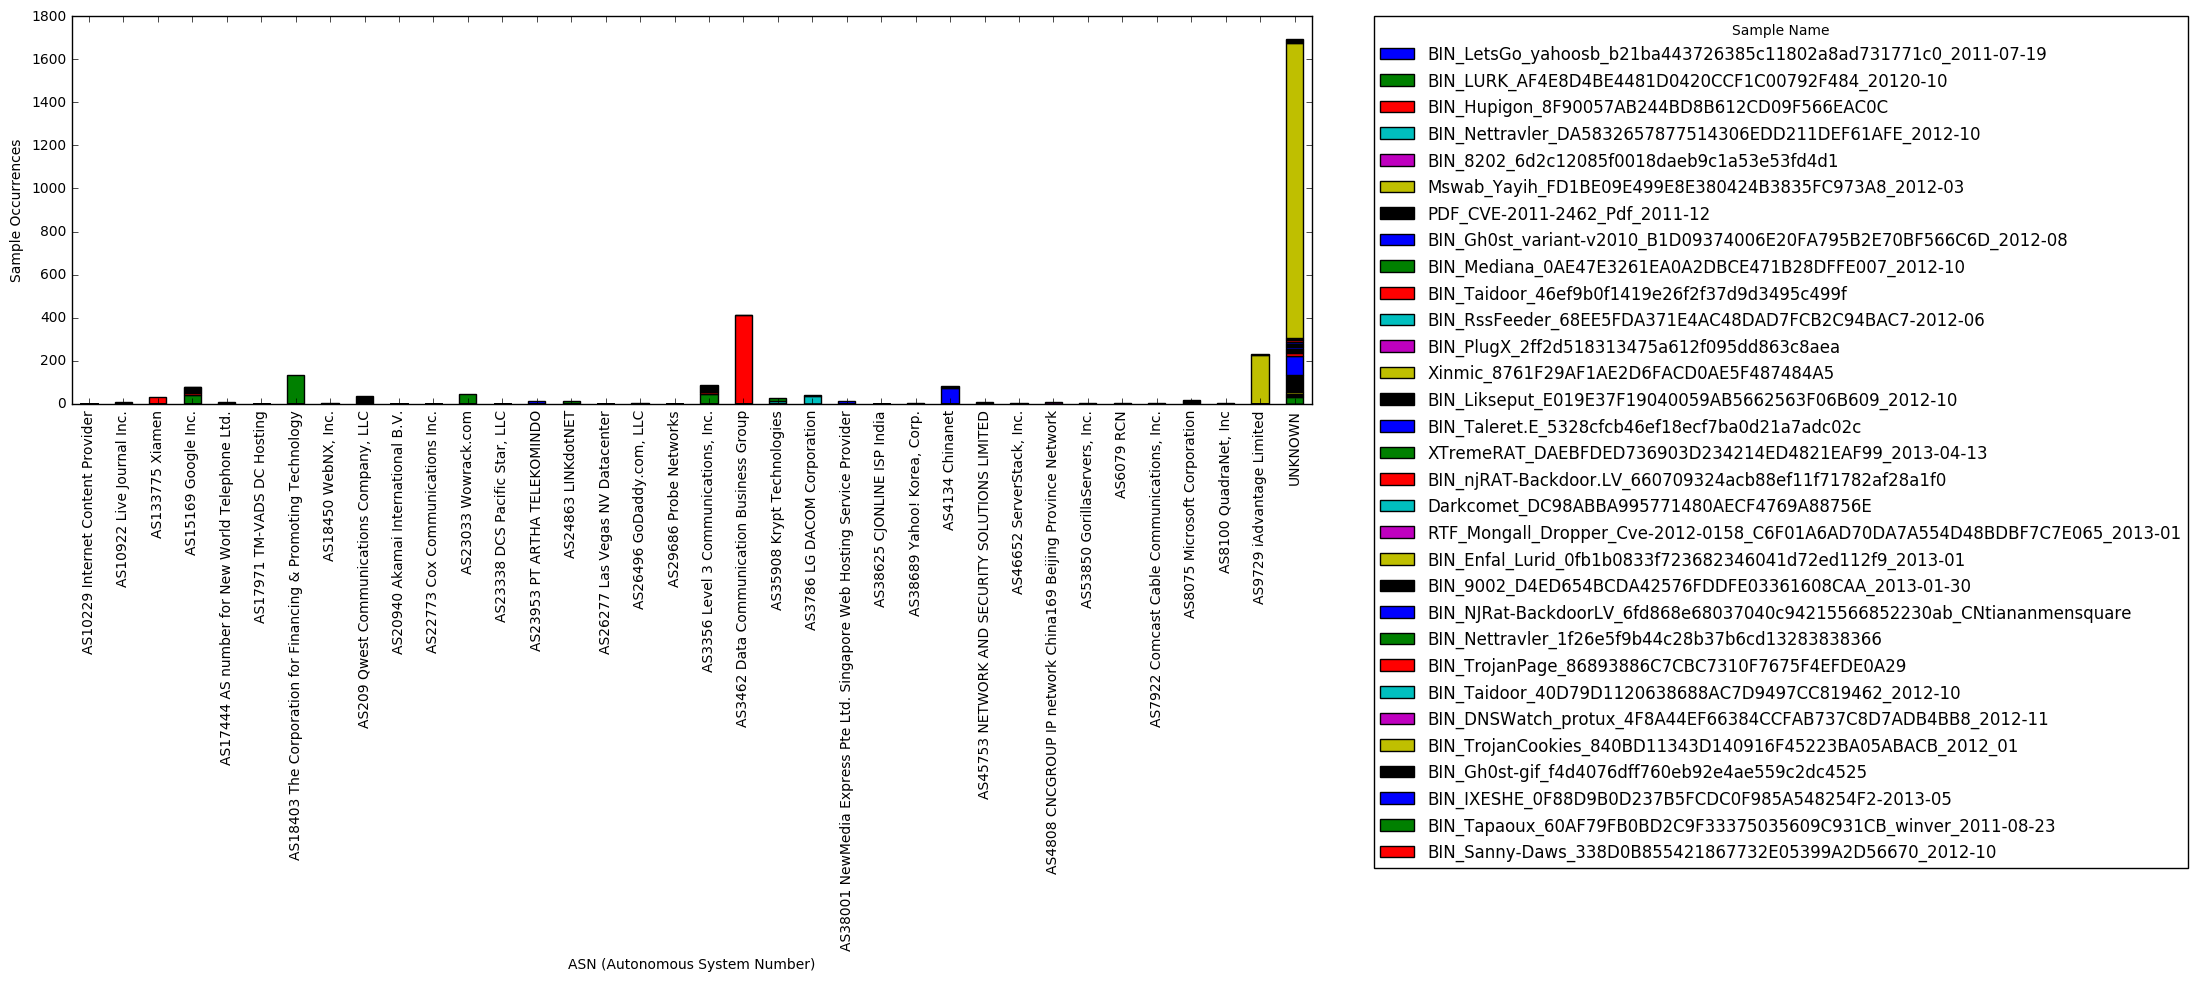

In [27]:
ax = box_plot_df_setup(conndf[conndf['threat'] == 'APT']['sample'], conndf[conndf['threat'] == 'APT']['maxmind_asn']).T.plot(kind='bar', stacked=True)
pylab.ylabel('Sample Occurrences')
pylab.xlabel('ASN (Autonomous System Number)')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Sample Name")

Just showing how to look at all the various AS contacted by a single sample. It also points out that the multiple parking above on L3 might be due to DNS requests.

In [28]:
conndf[conndf['sample'] == "BIN_8202_6d2c12085f0018daeb9c1a53e53fd4d1"][['maxmind_asn','id.resp_h']]

,maxmind_asn,id.resp_h
0,UNKNOWN,172.16.253.254
1,UNKNOWN,255.255.255.255
2,UNKNOWN,172.16.253.129
3,AS15169 Google Inc.,8.8.8.8
4,"AS3356 Level 3 Communications, Inc.",4.2.2.2
5,"AS53850 GorillaServers, Inc.",192.200.99.194
6,"AS53850 GorillaServers, Inc.",192.200.99.194
7,"AS53850 GorillaServers, Inc.",192.200.99.194
8,UNKNOWN,255.255.255.255
9,UNKNOWN,172.16.253.132


#### Top-N (it's everybody's favorite)
We have to look at them, let's see if we can make it interesting. Starting with the samples who transferred the most amount of bytes, broken down by which ports (in each sample) were used. A brief examination of some of the rows is also performed.

In [29]:
conndf['count'] = 1
grouped = conndf.groupby(['sample', 'id.resp_p']).sum()
grouped.sort('total_bytes', ascending = 0).head(10)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


ts  \
sample                                             id.resp_p                 
purplehaze                                         80.0       9.584038e+12   
                                                   1935.0     6.639908e+09   
BIN_LoadMoney_MailRu_dl_4e801b46068b31b82dac658... 80.0       4.242826e+02   
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B 25.0       2.326434e+13   
BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C26081... 587.0      1.359930e+09   
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F95... 80.0       5.559369e+11   
BIN_Cutwail_284Fb18Fab33C93Bc69Ce392D08Fd250_20... 80.0       4.179328e+03   
BIN_ZeusGameover_2012-02                           80.0       9.033005e+10   
BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013-... 53.0       1.357444e+09   
XTremeRAT_DAEBFDED736903D234214ED4821EAF99_2013... 336.0      1.631920e+10   

                                                               id.orig_p  \
sample                                             id.resp_p               
purplehaze                                         80.0       21282798.0   
                                                   1935.0        19212.0   
BIN_LoadMoney_MailRu_dl_4e801b46068b31b82dac658... 80.0          15894.0   
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B 25.0       51049454.0   
BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C26081... 587.0          1043.0   
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F95... 80.0         563199.0   
BIN_Cutwail_284Fb18Fab33C93Bc69Ce392D08Fd250_20... 80.0         117955.0   
BIN_ZeusGameover_2012-02                           80.0         102617.0   
BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013-... 53.0           1143.0   
XTremeRAT_DAEBFDED736903D234214ED4821EAF99_2013... 336.0         12601.0   

                                                              orig_bytes  \
sample                                             id.resp_p               
purplehaze                                         80.0         14945798   
                                                   1935.0          19172   
BIN_LoadMoney_MailRu_dl_4e801b46068b31b82dac658... 80.0             2648   
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B 25.0          7609979   
BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C26081... 587.0        10343395   
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F95... 80.0           663932   
BIN_Cutwail_284Fb18Fab33C93Bc69Ce392D08Fd250_20... 80.0            41749   
BIN_ZeusGameover_2012-02                           80.0            11477   
BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013-... 53.0          3580503   
XTremeRAT_DAEBFDED736903D234214ED4821EAF99_2013... 336.0         3482315   

                                                              resp_bytes  \
sample                                             id.resp_p               
purplehaze                                         80.0        172420089   
                                                   1935.0       37680956   
BIN_LoadMoney_MailRu_dl_4e801b46068b31b82dac658... 80.0         28139301   
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B 25.0          2814589   
BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C26081... 587.0             324   
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F95... 80.0          8706987   
BIN_Cutwail_284Fb18Fab33C93Bc69Ce392D08Fd250_20... 80.0          4931282   
BIN_ZeusGameover_2012-02                           80.0          3721029   
BIN_9002_D4ED654BCDA42576FDDFE03361608CAA_2013-... 53.0           117612   
XTremeRAT_DAEBFDED736903D234214ED4821EAF99_2013... 336.0               0   

                                                              missed_bytes  \
sample                                             id.resp_p                 
purplehaze                                         80.0            29203.0   
                                                   1935.0        8057592.0   
BIN_LoadMoney_MailRu_dl_4e801b46068b31b82dac658... 80.0                0.0   
BIN_Ku

In [30]:
# That port 1935 from above might be interesting, where's it going?
conndf[conndf['id.resp_p'] == 1935][['id.resp_h','proto']]

,id.resp_h,proto
5541,69.22.155.28,tcp
5561,68.142.111.111,tcp
6746,184.51.157.60,tcp
7095,184.84.220.133,tcp
7509,184.51.157.60,tcp


In [31]:
# Same with port 336
conndf[conndf['id.resp_p'] == 336][['id.resp_h','proto']]

,id.resp_h,proto
0,197.163.56.70,tcp
3,197.163.56.70,tcp
4,197.163.56.70,tcp
5,197.163.56.70,tcp
6,197.163.56.70,tcp
7,197.163.56.70,tcp
10,197.163.56.70,tcp
11,197.163.56.70,tcp
12,197.163.56.70,tcp
15,197.163.56.70,tcp


### SMTP, because who doesn't love some SPAM

In [32]:
#smtpdf.sample.value_counts()
smtpdf['sample'].value_counts()

BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B         4085
BIN_Sanny-Daws_338D0B855421867732E05399A2D56670_2012-10       2
BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C2608150DD18         1
Name: sample, dtype: int64

#### Hosts aka Open Relays
Looks like we've found quite a few (wonder if they still work). I'm also amazed at how many are included with one sample. There are at most 3 other hosts in this list not related to the Asprox sample, but it seems that Asprox sends quite a bit of email and includes a pretty good list of open relays.

In [33]:
print("Unique Hosts found as the HELO portion of SMTP traffic: %s" % smtpdf.helo.nunique())
print("")
print("Some of the examples")
print(smtpdf.helo.value_counts().head(10))

Unique Hosts found as the HELO portion of SMTP traffic: 89

Some of the examples
apostille123.com              132
bestcatscratchpost.com        112
costaricaposters.com          109
olgapost.com                  105
highschoolapostles.com        104
kevinpostmotors.com            97
posteraday.com                 92
postroomsupplies.com           89
alliedpostal.com               87
bancopostaclienteitaly.com     87
Name: helo, dtype: int64


#### Patterns in email
Maybe we can find some patterns in senders and subjects?

In [34]:
smtpdf['count'] = 1
grouped = smtpdf[smtpdf['from'] != "-"][['from','subject','count']].groupby(['from', 'subject']).sum()
grouped.sort('count', ascending = 0).head(20)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:3: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  app.launch_new_instance()


,,count
from,subject,
Economy Shipping <support_id81@highperfpostgresql.com>,Delivery Notification ID#EN95887556F,6
Next Day Air Saver <message_id98@olgapost.com>,Delivery Notification ID#EN79318987H,4
Next Day Air Saver <us_52@apostille123.com>,Delivery Status Notification ID#EN68982189X,3
Priority Mail <status_85@hissignpost.com>,Delivery Status Notification ID#EN43751461X,3
Next Day Air Saver <us_86@apostille123.com>,Delivery Notification ID#EN51755931H,3
Standard Shipping <status_id46@goppost.com>,Delivery Notification ID#EN28866699H,3
Next Day Air Saver <us_82@apostille123.com>,Delivery Status Notification ID#EN31327537Y,3
Mail International <customer_id62@posteraday.com>,Delivery Status Notification,3
Postal Service <item_37@highperfpostgres.com>,Delivery Status Notification,3


Network traffic is fine and dandy, but now it's time for some more eye-candy!
<div style="float: right;"><img src="files/images/eyecandy.jpg" width="300px"/></div>

### Files
It's nice to have the context around how systems communicate. We've got some great stats/data surrounding the c2 and delivery mechanisms, so let's see how they related to the files that get transferred. Bro can extract files from IRC, SMTP, HTTP, and FTP out of the box.
#### Summary information
What's the most popular, and what does it look like per-protocol?

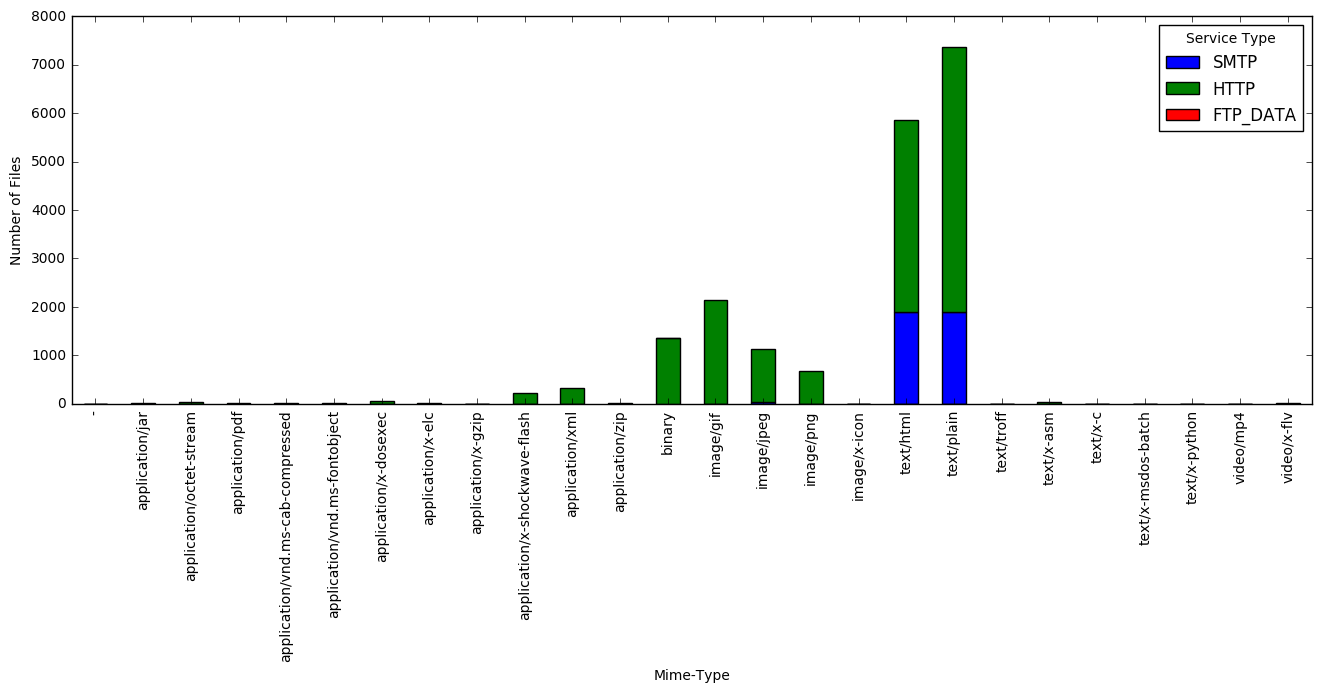

In [35]:
ax = box_plot_df_setup(filesdf['source'], filesdf['mime_type']).T.plot(kind='bar', stacked=True)
pylab.xlabel('Mime-Type')
pylab.ylabel('Number of Files')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, title="Service Type")

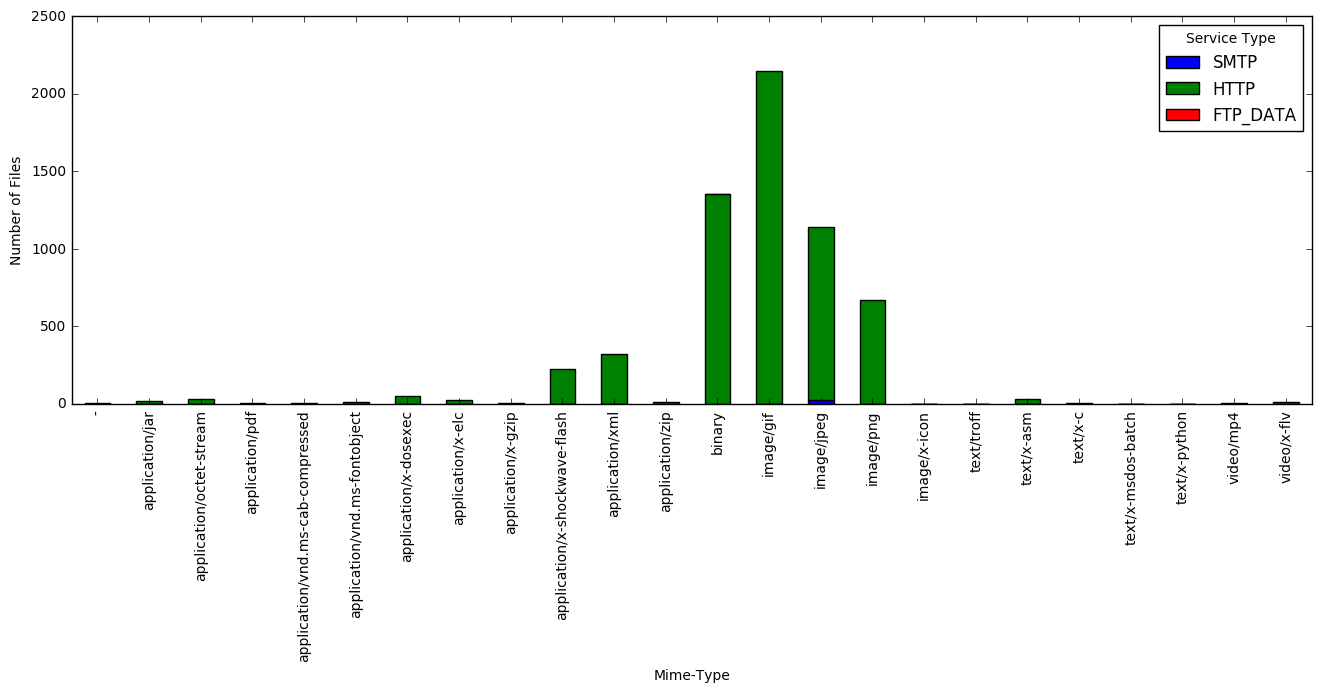

In [36]:
ax = box_plot_df_setup(filesdf.loc[(filesdf["mime_type"] != 'text/html') & (filesdf['mime_type'] != 'text/plain')]['source'], filesdf.loc[(filesdf["mime_type"] != 'text/html') & (filesdf['mime_type'] != 'text/plain')]['mime_type']).T.plot(kind='bar', stacked=True)
pylab.xlabel('Mime-Type')
pylab.ylabel('Number of Files')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, title="Service Type")

In [37]:
filesdf['count'] = 1
filesdf[filesdf['filename'] != '-'][['source','mime_type','seen_bytes','count']].groupby(['source','mime_type']).sum().sort('count', ascending=0).head(10)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


seen_bytes  count
source mime_type                               
SMTP   image/jpeg              7554332.0     26
HTTP   binary                  2922872.0     13
       application/x-dosexec   1717057.0     12
       application/pdf          126691.0      7
       image/gif               1082697.0      2
       image/png                  2534.0      2
       image/jpeg                 9972.0      1
       text/plain                57254.0      1

#### Filenames
I wonder if filenames get reused, or perhaps there are some super common ones that might be interesting to look for in network traffic.

In [38]:
filesdf[filesdf['filename'] != '-'][['source','mime_type','filename','count']].groupby(['source','mime_type','filename']).sum().sort('count', ascending=0).head(10)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


count
source mime_type             filename                                   
HTTP   binary                COMMON.BIN                                6
       application/x-dosexec contacts.exe                              3
                             readme.exe                                2
       image/png             ad516503a11cd5ca435acc9bb6523536.png      2
       binary                setusating.bin                            2
       application/pdf       19b9c.pdf                                 1
SMTP   image/jpeg            Jun_06_2013__09_46_17.jpg                 1
                             Jun_06_2013__09_46_19.jpg                 1
                             Jun_06_2013__09_46_20.jpg                 1
                             Jun_06_2013__09_46_21.jpg                 1

In [39]:
filesdf[filesdf['filename'] != '-'][['sample','mime_type','filename','count']].groupby(['sample','mime_type','filename']).sum().sort('count', ascending=0).head(10)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


count
sample                                             mime_type             filename                                   
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B binary                COMMON.BIN                                6
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F95... image/png             ad516503a11cd5ca435acc9bb6523536.png      2
BIN_ZeusGameover_2012-02                           application/x-dosexec contacts.exe                              2
BIN_Zeus_b1551c676a54e9127cd0e7ea283b92cc-2012-04  binary                setusating.bin                            2
BIN_ArdamaxKeylogger_E33AF9E602CBB7AC3634C26081... image/jpeg            Jun_06_2013__09_46_14.jpg                 1
BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321BF84B binary                fp10na.dll.crp                            1
                                                                         pg.dll.crp                                1
BIN_Vobfus_634AA845F5B0B519B6D8A8670B994906_201... application/x-dosexec 2640                                      1
                                                                         9091                                      1
BIN_ZeusGameover_2012-02                           application/pdf       edd79.pdf                                 1

### Notice
#### What things should we pay attention to?
We got some interesting coverage of Bro notices, any of these could provide an interesting place to launch an investigation from.

In [40]:
noticedf['count'] = 1
noticedf[['note','msg','count']].groupby(['note','msg']).sum().sort('count', ascending=0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


count
note                                msg                                                      
SSL::Invalid_Server_Cert            SSL certificate validation failed with (unable ...    199
                                    SSL certificate validation failed with (certifi...     14
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 68%  Last...      9
SSL::Invalid_Server_Cert            SSL certificate validation failed with (self si...      5
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 41%  Last...      3
                                    Malware Hash Registry Detection rate: 32%  Last...      3
                                    Malware Hash Registry Detection rate: 36%  Last...      2
                                    Malware Hash Registry Detection rate: 60%  Last...      1
                                    Malware Hash Registry Detection rate: 55%  Last...      1
                                    Malware Hash Registry Detection rate: 55%  Last...      1
                                    Malware Hash Registry Detection rate: 50%  Last...      1
                                    Malware Hash Registry Detection rate: 41%  Last...      1
                                    Malware Hash Registry Detection rate: 40%  Last...      1
                                    Malware Hash Registry Detection rate: 32%  Last...      1
                                    Malware Hash Registry Detection rate: 36%  Last...      1
                                    Malware Hash Registry Detection rate: 27%  Last...      1
                                    Malware Hash Registry Detection rate: 25%  Last...      1
                                    Malware Hash Registry Detection rate: 24%  Last...      1
                                    Malware Hash Registry Detection rate: 23%  Last...      1
Signatures::Sensitive_Signature     10.0.2.15: ATTACK-RESPONSES Microsoft cmd.exe b...      1
Scan::Address_Scan                  192.168.248.165 scanned at least 25 unique host...      1
                                    192.168.248.165 scanned at least 25 unique host...      1
                                    192.168.248.165 scanned at least 25 unique host...      1
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 81%  Last...      1

In [41]:
# We can get a slightly different look at the world by throwing some ports into the mix! Looks like we might have some winners here.
noticedf[['note','msg','id.resp_p','count']].groupby(['note','msg','id.resp_p']).sum().sort('count', ascending=0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


count
note                                msg                                                id.resp_p       
SSL::Invalid_Server_Cert            SSL certificate validation failed with (unable ... 443.0        120
                                                                                       9001          56
                                    SSL certificate validation failed with (certifi... 443.0         14
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 68%  Last... 80             9
SSL::Invalid_Server_Cert            SSL certificate validation failed with (unable ... 80             5
                                    SSL certificate validation failed with (self si... 443            3
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 32%  Last... 80             3
                                    Malware Hash Registry Detection rate: 41%  Last... 80             3
SSL::Invalid_Server_Cert            SSL certificate validation failed with (unable ... 44945          3
                                                                                       10203          3
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 36%  Last... 80             2
SSL::Invalid_Server_Cert            SSL certificate validation failed with (self si... 443.0          2
                                    SSL certificate validation failed with (unable ... 9101           2
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 27%  Last... 80             1
                                    Malware Hash Registry Detection rate: 32%  Last... 80             1
                                    Malware Hash Registry Detection rate: 36%  Last... 80             1
                                    Malware Hash Registry Detection rate: 41%  Last... 80             1
                                    Malware Hash Registry Detection rate: 40%  Last... 80             1
                                    Malware Hash Registry Detection rate: 24%  Last... 80             1
                                    Malware Hash Registry Detection rate: 50%  Last... 8888           1
                                    Malware Hash Registry Detection rate: 55%  Last... 80             1
                                    Malware Hash Registry Detection rate: 55%  Last... 80             1
                                    Malware Hash Registry Detection rate: 60%  Last... 80             1
                                    Malware Hash Registry Detection rate: 25%  Last... 80             1
Scan::Address_Scan                  192.168.248.165 scanned at least 25 unique host... -              1
TeamCymruMalwareHashRegistry::Match Malware Hash Registry Detection rate: 23%  Last... 80             1
Signatures::Sensitive_Signature     10.0.2.15: ATTACK-RESPONSES Microsoft cmd.exe b... 443.0          1
Scan::Address_Scan                  192.168.248.165 scanned at least 25 unique host... -              1
                                    192.168.248.165 scanned at least 25 unique host... -              1
SSL::Invalid_Server_Cert            SSL certificate validation failed with (unable ... 39030          1
                                                                                       11443          1
                                                                                       9060           1
                                                                                       9002           1
                                                                                       8443           1
                                                                                       7540           1
                                                                                       6001           1
                                                                                       5251           1
                                          

In [42]:
noticedf[noticedf['note'] == 'Scan::Address_Scan']['sample']

2    BIN_Cutwail-Pushdo(1)_582DE032477E099EB1024D84...
1    BIN_Cutwail-Pushdo(2)_582DE032477E099EB1024D84...
0    BIN_Kuluoz-Asprox_9F842AD20C50AD1AAB41F20B321B...
Name: sample, dtype: object

We've come full circle, it looks like we've got more confirmation that we have some malware samples that are really good at SPAM, and disply it by connecting to lots of hosts in rapid succession.

### SSL
#### Stats
We saw some examples above where we had lots of SSL alerts, and some of them were on strange ports. Here we can take a look at the breakdown of SSL traffic and it's associated ports. I suspect some interesting things will fallout.

In [43]:
ssldf['id.resp_p'].value_counts()

443.0      271
9001.0      57
80.0         5
10203.0      3
44945.0      3
9101.0       2
5001.0       1
7540.0       1
6001.0       1
9060.0       1
9002.0       1
8443.0       1
11443.0      1
5251.0       1
39030.0      1
22.0         1
Name: id.resp_p, dtype: int64

In [44]:
ssldf.subject.value_counts().head(10)

-                                                                                                                                         46
emailAddress=marry.smith@ltu.edu,CN=ITU Server,OU=VeriSign Trust Network,O=Internet Widgits Pty Ltd,L=Salisbury,ST=North Carolina,C=US    24
CN=*.google.com,O=Google Inc,L=Mountain View,ST=California,C=US                                                                            7
CN=www.3ktww4bg.net                                                                                                                        6
CN=eric-office                                                                                                                             5
CN=www.ktq2go444i.net                                                                                                                      5
CN=*.gstatic.com,O=Google Inc,L=Mountain View,ST=California,C=US                                                                           4
CN=www.bnbhck

In [45]:
ssldf['count'] = 1
ssldf[['version','cipher','count']].groupby(['version','cipher']).sum().sort('count', ascending=0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:2: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  from ipykernel import kernelapp as app


count
version cipher                                 
TLSv10  TLS_DHE_RSA_WITH_AES_256_CBC_SHA    211
SSLv3   TLS_RSA_WITH_RC4_128_MD5             70
        TLS_RSA_WITH_RC4_128_SHA             21
TLSv10  TLS_RSA_WITH_RC4_128_SHA             18
        TLS_RSA_WITH_RC4_128_MD5             15
-       -                                    13
TLSv10  TLS_RSA_WITH_AES_128_CBC_SHA          3

Since we've got a decent grasp on the ports used, the types of ciphers present as well as popular certs that were seen in malware, perhaps there are a couple of ways we can begin to relate that information back to samples to get an idea of what the sample might be doing or how it works.

In [46]:
ssldf[['sample','server_name','id.resp_p','count']].groupby(['sample','id.resp_p','server_name']).sum().sort('count', ascending=0)

/Users/cch/anaconda/lib/python3.5/site-packages/ipykernel/__main__.py:1: FutureWarning: sort(columns=....) is deprecated, use sort_values(by=.....)
  if __name__ == '__main__':


,,,count
sample,id.resp_p,server_name,
purplehaze,443.0,-,43
PDF_CVE-2011-2462_Pdf_2011-12,443.0,-,36
BIN_ZeroAccess_Sirefef_C2A9CCC8C6A6DF1CA1725F955F991940_2013-08,443.0,-,16
BIN_Cutwail-Pushdo(2)_582DE032477E099EB1024D84C73E98C1,443.0,-,9
BIN_Ramnitpcap_2012-01,443.0,-,7
BIN_Vobfus_634AA845F5B0B519B6D8A8670B994906_2012-12,443.0,-,5
BIN_TrojanPage_86893886C7CBC7310F7675F4EFDE0A29,443.0,-,5
BIN_Enfal_Lurid_0fb1b0833f723682346041d72ed112f9_2013-01,443.0,-,4
BIN_Googledocs_macadocs_2012-12,443.0,-,4


#### We can even view the above in a fancy D3 layout!
<div style="float: center;"><img src="files/images/ssl_radial.png" width="800px"/></div>


To run the visualization in your web browser:

1. Run the code in the next cell
2. 'cd bsides_austin'
3. 'python -m SimpleHTTPServer 9999'
4. Point your brower at the html file [http://localhost:9999/ssl_cartesian.html](http://localhost:9999/ssl_radial.html)
5. ^C to exit the webserver after you're done enjoying the D3 graph

In [47]:
data = {'name' : 'ssl'}
samples = list(set(ssldf['sample'].tolist()))
data['children'] = list()
sampleindex = 0
for sample in samples:
    data['children'].append({'name' : sample, 'children' : list()})
    ports = set(ssldf[ssldf['sample'] == sample]['id.resp_p'].tolist())
    portindex = 0
    for port in ports:
        data['children'][sampleindex]['children'].append({'name' : str(port), 'children' : list()})
        hostnames = set(list(ssldf.loc[(ssldf['id.resp_p'] == int(port)) & (ssldf['sample'] == sample)]['server_name']))
        for hostname in hostnames:
            data['children'][sampleindex]['children'][portindex]['children'].append({'name' : hostname, 'size' : 1}) 
        portindex += 1
    sampleindex += 1
json.dump(data, open('ssl.json', 'w'))

To show how easy D3 can be once you have the JSON output, you can also point your browser (after folliwng the steps above) to [http://localhost:9999/ssl_cartesian.html](http://localhost:9999/ssl_cartesian.html)

And you'll get some output similar to:
<div style="float: center;"><img src="files/images/ssl_cartesian.png" width="800px"/></div>

<br><br><br>
Note: If you run these at home, you can zoom in and zoom out with your browswer hot-keys to get a much nicer view of the graph.

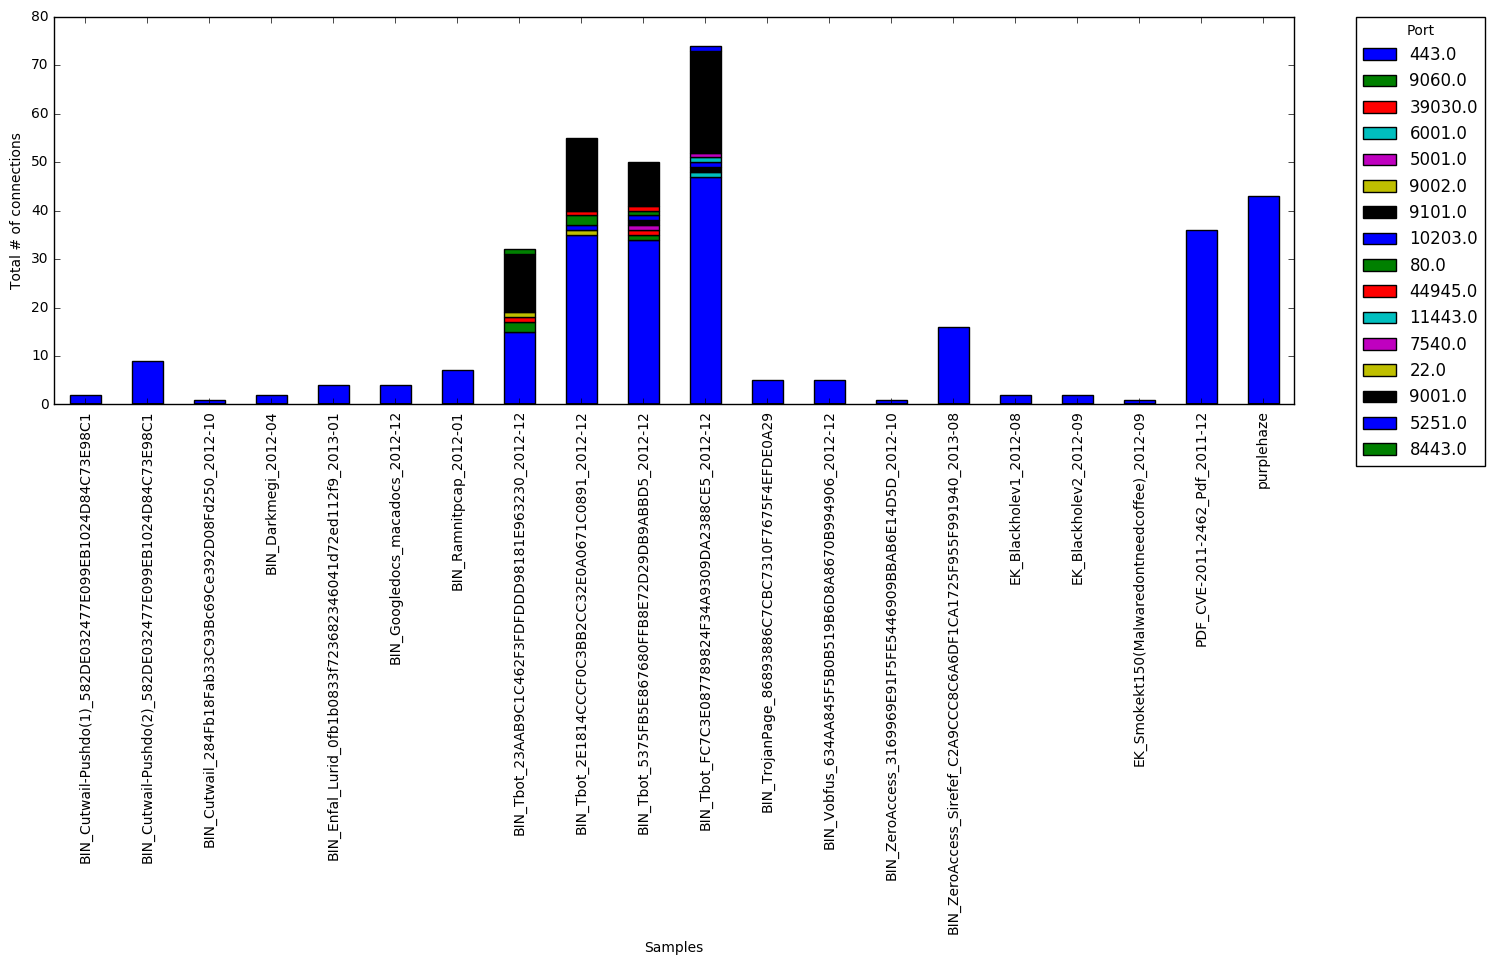

In [48]:
# Ports per sample
ax = box_plot_df_setup(ssldf['id.resp_p'], ssldf['sample']).T.plot(kind='bar', stacked=True)
pylab.ylabel('Total # of connections')
pylab.xlabel('Samples')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Port")

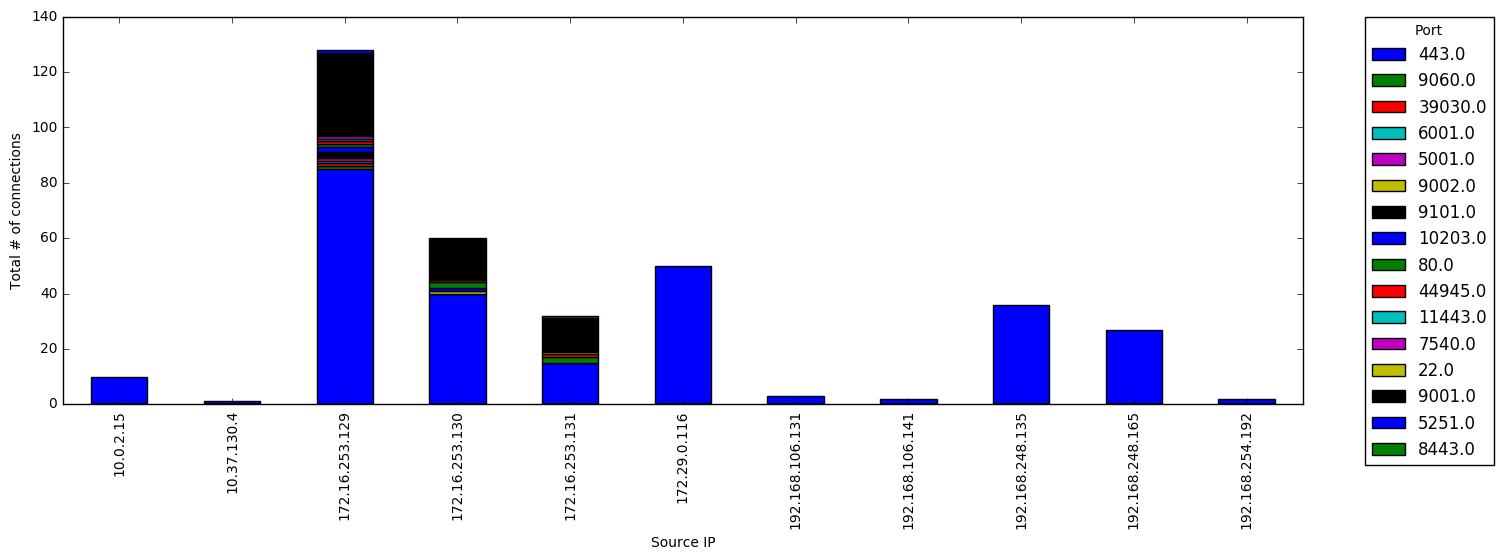

In [49]:
# Or as you might see it in an operational sense...
ax = box_plot_df_setup(ssldf['id.resp_p'], ssldf['id.orig_h']).T.plot(kind='bar', stacked=True)
pylab.ylabel('Total # of connections')
pylab.xlabel('Source IP')
patches, labels = ax.get_legend_handles_labels()
ax.legend(patches, labels, bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0., title="Port")

#### Spoiler Alert!!
Tbot uses TOR for communication. (http://contagiodump.blogspot.com/2012/12/dec-2012-skynet-tor-botnet-trojantbot.html)

### Weirdness
The weird.log shows protocol issues/anomalies as well as information pertaining to possible data loss, etc... We weren't able to find anything exciting in there, but that doesn't mean you won't!

In [50]:
weirddf.name.value_counts()

data_before_established              169
unescaped_special_URI_char           166
possible_split_routing               164
line_terminated_with_single_CR       133
NUL_in_line                          111
unknown_protocol_2                    71
bad_HTTP_request                      65
DNS_Conn_count_too_large              51
inappropriate_FIN                     34
HTTP_version_mismatch                 21
connection_originator_SYN_ack         20
unmatched_HTTP_reply                   9
truncated_link_frame                   9
window_recision                        8
SYN_inside_connection                  6
above_hole_data_without_any_acks       5
DNS_truncated_ans_too_short            5
unescaped_%_in_URI                     5
premature_connection_reuse             4
DNS_label_too_long                     4
DNS_truncated_RR_rdlength_lt_len       4
dns_changed_number_of_responses        3
DNS_label_len_gt_pkt                   3
SYN_with_data                          2
truncated_IP    

## Try this at home
<div style="float: center;"><img src="files/images/tryathome.jpg"/></div>
## What could go wrong?